In [10]:
import numpy as np
import matplotlib.pyplot as plt
from visualizations.data import viz_data_prep as vdp

In [3]:
input_params = {
"k": 115740740740,
"lambda": 1490000000000000000,
"delta": 7425000000000000,
"capPayoff": 10000000000000000000,
"capNotional": 60000000000000000000000,
"capLeverage": 5000000000000000000,
"circuitBreakerWindow": 2592000,
"circuitBreakerMintTarget": 5000000000000000000000,
"maintenanceMarginFraction": 40000000000000000,
"maintenanceMarginBurnRate": 50000000000000000,
"liquidationFeeRate": 50000000000000000,
"tradingFeeRate": 750000000000000,
"minCollateral": 100000000000000,
"priceDriftUpperLimit": 87000000000000,
"averageBlockTime": 0
}

## Explanations for formula based features

In [4]:
ask_delta = vdp.ask(1, input_params['delta']/1e18, 0, 0)
bid_delta = vdp.bid(1, input_params['delta']/1e18, 0, 0)

ask_impact = vdp.ask(1, 0, input_params['lambda']/1e18, 0.01)
print(f'''
Funding rate per day: {round(vdp.funding_per_sec(input_params['k']/1e18) * 86400 * 100, 2)}%
Static bid-ask spread: {round(100*((ask_delta/bid_delta) - 1), 2)}%
Market Impact (for trade with size 1% of OI cap): {round((vdp.ask(1, 0, input_params['lambda']/1e18, 0.01) - 1) * 100, 2)}%
Notional cap as percentage of 8mn OVL: {round(input_params['capNotional'] * 100/(1e18 * 8_000_000), 2)}%
Max allowed price change of longer TWAP: {round(vdp.price_drift_allowed(input_params['priceDriftUpperLimit']/1e18, 3600) * 100, 2)}%
''')


Funding rate per day: 2.0%
Static bid-ask spread: 1.5%
Market Impact (for trade with size 1% of OI cap): 1.5%
Notional cap as percentage of 8mn OVL: 0.75%
Max allowed price change of longer TWAP: 36.78%



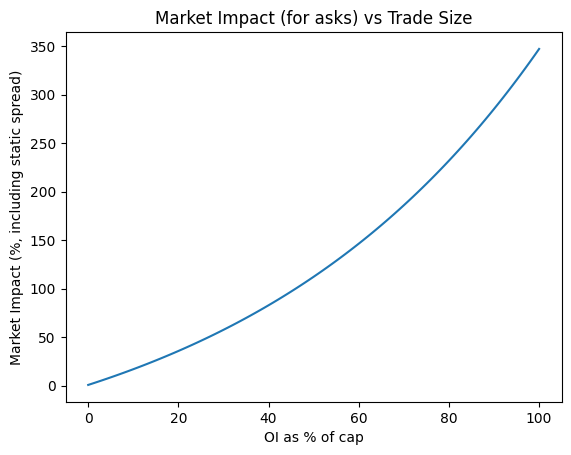

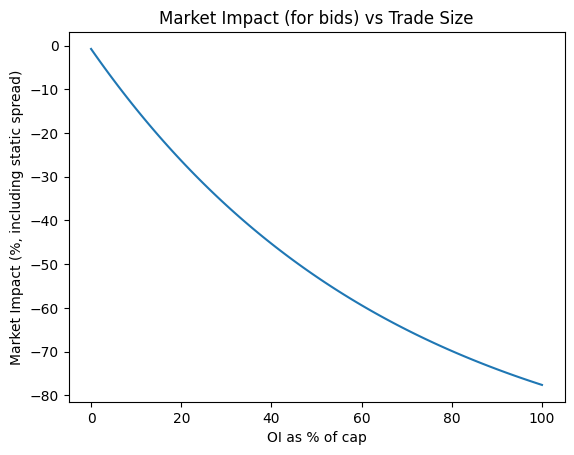

In [22]:
base_price = 1
ask_list = []
bid_list = []
oi_perc_range = np.arange(0, 101, 1)
for oi_perc in oi_perc_range:
    bid_ask_inputs = (
        base_price,
        input_params['delta']/1e18,
        input_params['lambda']/1e18,
        oi_perc/100
    )
    ask_list.append(
        vdp.ask(*bid_ask_inputs)
    )
    bid_list.append(
        vdp.bid(*bid_ask_inputs)
    )

ask_perc = [(ask - 1) * 100 for ask in ask_list]
bid_perc = [(bid - 1) * 100 for bid in bid_list]

# Plot ask_perc vs oi_perc
plt.plot(oi_perc_range, ask_perc)
plt.xlabel('OI as % of cap')
plt.ylabel('Market Impact (%, including static spread)')
plt.title('Market Impact (for asks) vs Trade Size')
plt.show()

# Plot bid_perc vs oi_perc
plt.plot(oi_perc_range, bid_perc)
plt.xlabel('OI as % of cap')
plt.ylabel('Market Impact (%, including static spread)')
plt.title('Market Impact (for bids) vs Trade Size')
plt.show()